In [46]:
!pip install torch torchvision matplotlib tqdm pillow==11.0.0 -qU

ERROR: Operation cancelled by user


In [47]:
!git clone https://github.com/EyadAlN3imi/DS372-Forensics.git

fatal: destination path 'DS372-Forensics' already exists and is not an empty directory.


In [48]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import transforms
import seaborn as sns
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [49]:
data_path = "/content/DS372-Forensics/Datasets/BPA_DATA"
os.listdir(data_path)

['FINAL_ALL_DATA.csv', 'FINAL_ALL_IMAGES']

In [50]:
df = pd.read_csv('/content/DS372-Forensics/Datasets/BPA_DATA/FINAL_ALL_DATA.csv')
df.head()

,image_name,class,source_dataset
0,C1_beat.jpg,beating,beating
1,C10_beat.jpg,beating,beating
2,C11_beat.jpg,beating,beating
3,C12_beat.jpg,beating,beating
4,C2_beat.jpg,beating,beating


In [51]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")
total_size_bytes = 0
for img_name in df['image_name']:
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        total_size_bytes += os.path.getsize(img_path)

total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total images storage size: {total_size_mb:.2f} MB")

Total images storage size: 16.55 MB


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_name      331 non-null    object
 1   class           331 non-null    object
 2   source_dataset  331 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


In [53]:
df.describe().T

,count,unique,top,freq
image_name,331,331,1-107575.jpg,1
class,331,3,blood drip,202
source_dataset,331,4,paper75,101


In [54]:
freq_table = pd.DataFrame({
    'Count': df['class'].value_counts(),
    'Percentage': df['class'].value_counts(normalize=True) * 100
})

freq_table['Cumulative %'] = freq_table['Percentage'][::-1].cumsum()[::-1].round(2)
freq_table['Percentage'] = freq_table['Percentage'].round(2)

freq_table

,Count,Percentage,Cumulative %
class,,,
blood drip,202,61.03,100.00
gun shot,68,20.54,38.97
beating,61,18.43,18.43


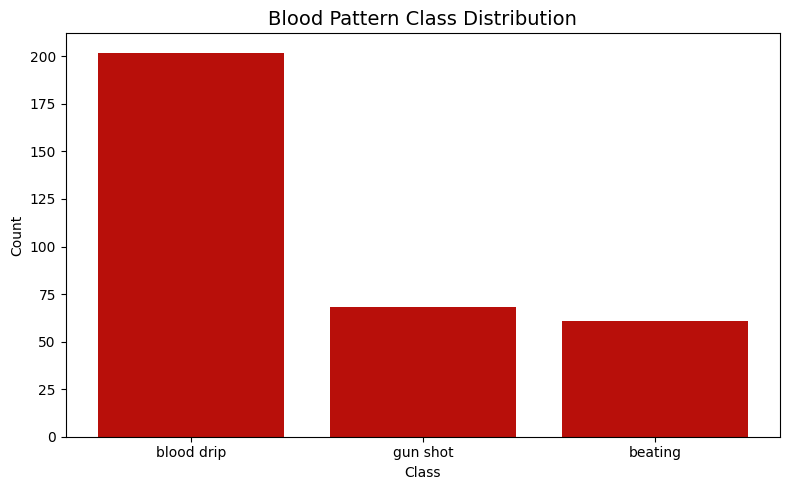

In [55]:
counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color="#B80F0A")

plt.title("Blood Pattern Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()

plt.show()

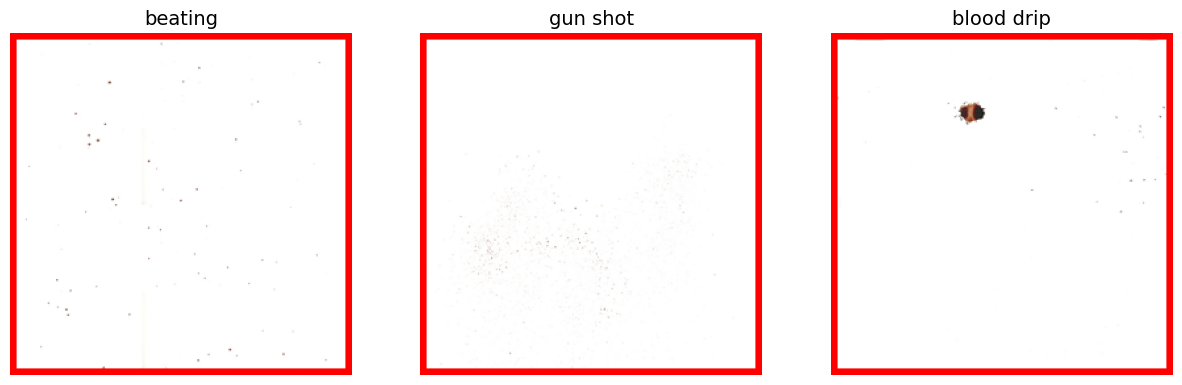

In [56]:
classes = df['class'].unique()

fig, ax = plt.subplots(1, len(classes), figsize=(5 * len(classes), 6))

for i, cls in enumerate(classes):
    subset = df[df['class'] == cls]
    img_name = subset.sample(1)['image_name'].values[0]
    path = os.path.join(img_dir, img_name)

    img = Image.open(path).resize((250, 250))

    img = ImageOps.expand(img, border=5, fill="red")

    ax[i].imshow(img)
    ax[i].set_title(cls, fontsize=14)
    ax[i].axis("off")

plt.subplots_adjust(wspace=0.2)
plt.show()

In [57]:
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def get_dino_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        emb = dino_model(img)
    return emb.cpu().numpy().flatten()

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


In [58]:
embeddings = []
labels = []

print(f"Processing {len(df)} images...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_dir, row['image_name'])
    label = row['class']

    emb = get_dino_embedding(img_path)
    embeddings.append(emb)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"\nEmbeddings extracted")
print(f"  - Shape: {embeddings.shape}")
print(f"  - Embedding dimension: {embeddings.shape[1]}")


Processing 331 images...


100%|██████████| 331/331 [01:34<00:00,  3.52it/s]


Embeddings extracted
  - Shape: (331, 384)
  - Embedding dimension: 384


In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

print(f"✓ Features normalized")
print(f"  - Shape: {X_scaled.shape}")
print(f"  - Mean: {X_scaled.mean(axis=0)[:5]}...")
print(f"  - Std: {X_scaled.std(axis=0)[:5]}...")

✓ Features normalized
  - Shape: (331, 384)
  - Mean: [ 3.2413403e-09 -3.1513029e-08  8.9677080e-08 -2.3330896e-08
  1.1668825e-07]...
  - Std: [1.         1.0000001  1.0000001  0.99999976 1.0000001 ]...


In [60]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_scaled = pca.fit_transform(embeddings)

pca_df = pd.DataFrame({
    'PC1': X_scaled[:, 0],
    'PC2': X_scaled[:, 1],
    'Class': labels
})

fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Class',
    title='Interactive PCA Visualization',
    hover_data=['Class'],
    opacity=0.8
)

fig.update_traces(marker=dict(size=6))
fig.show()


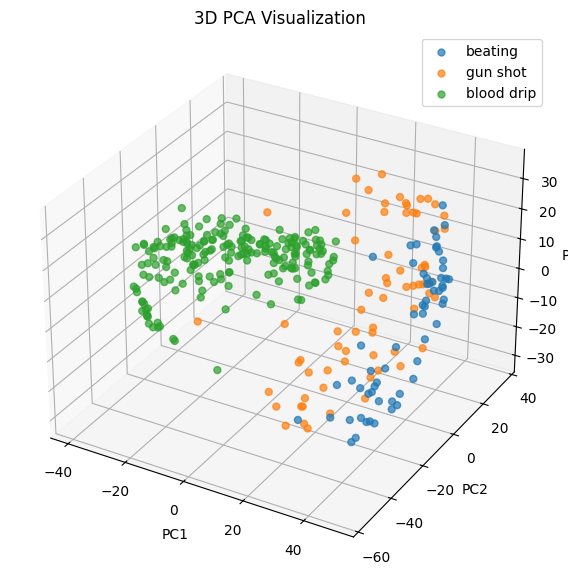

In [61]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_scaled = pca.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for cls in classes:
    mask = labels == cls
    ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], X_scaled[mask, 2], s=25, label=cls, alpha=0.7)

ax.set_title("3D PCA Visualization")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.legend()
plt.show()


In [62]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(embeddings).flatten()

df_pc1 = pd.DataFrame({
    "PC1": pc1,
    "Class": labels})
pc1_by_class = {cls: df_pc1[df_pc1["Class"] == cls]["PC1"].values for cls in np.unique(labels)}

pc1_by_class

{np.str_('beating'): array([46.22147 , 39.13607 , 34.02896 , 33.029125, 41.88763 , 43.738976,
        46.800926, 44.969566, 46.525146, 46.625458, 42.752945, 32.648952,
        45.15043 , 40.4184  , 41.558884, 39.13323 , 40.844254, 28.31998 ,
        32.622723, 29.876759, 34.077045, 23.685495, 36.89527 , 34.570377,
        46.3271  , 45.125164, 45.737453, 46.30878 , 45.62334 , 47.149593,
        44.589584, 24.534277, 23.1641  , 31.22162 , 36.492256, 42.18868 ,
        39.677647, 41.678127, 45.545357, 49.56977 , 48.273335, 46.431057,
        45.398888, 41.541306, 47.239063, 44.512627, 40.422825, 41.612152,
        34.477596, 44.648727, 45.742405, 43.933376, 46.830135, 37.18698 ,
        37.166077, 45.67697 , 34.404625, 43.41142 , 32.98229 , 40.04544 ,
        34.139267], dtype=float32),
 np.str_('blood drip'): array([  7.0108585 , -12.225557  , -12.168839  , -14.622049  ,
        -14.376981  , -12.507153  , -16.27566   , -17.89955   ,
        -14.658547  , -16.317173  , -28.34097   , -31

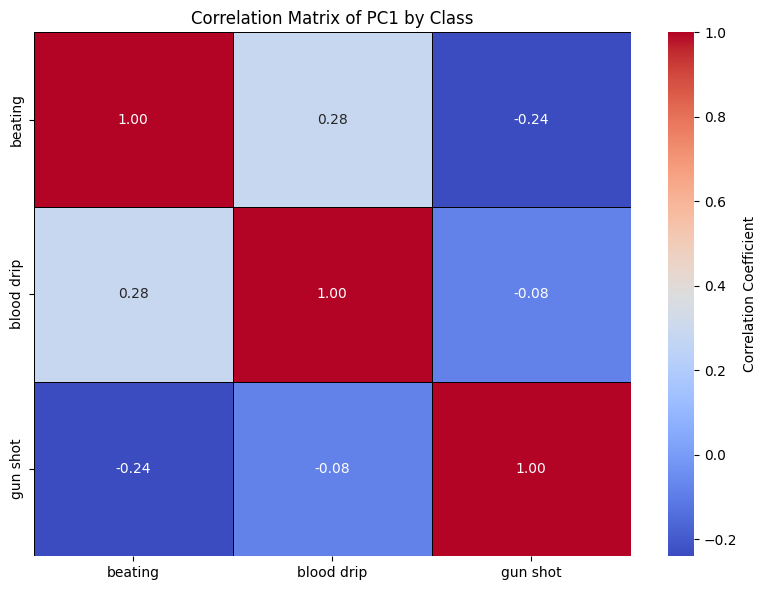

In [63]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_scaled).flatten()
classes = np.unique(labels)

df_pc1 = pd.DataFrame({"PC1": pc1, "Class": labels})
pc1_by_class = {cls: df_pc1[df_pc1["Class"] == cls]["PC1"].values for cls in classes}
pc1_data = {cls: pd.Series(pc1_by_class[cls]) for cls in classes}
pc1_df = pd.DataFrame(pc1_data)

correlation_matrix = pc1_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black',
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of PC1 by Class')
plt.tight_layout()
plt.savefig('pc1_correlation_heatmap.png')
plt.show()



In [64]:
tsne = TSNE(
    n_components=3,
    learning_rate='auto',
    init='pca',
    perplexity=30,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE - Shape: {X_tsne.shape}")

t-SNE - Shape: (331, 3)


In [65]:
fig = px.scatter_3d(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    z=X_tsne[:, 2],
    color=labels,
    title="3D t-SNE Visualization",
    labels={
        "x": "t-SNE 1",
        "y": "t-SNE 2",
        "z": "t-SNE 3",
        "color": "Class"
    }
)

fig.update_traces(marker=dict(size=4))
fig.show()

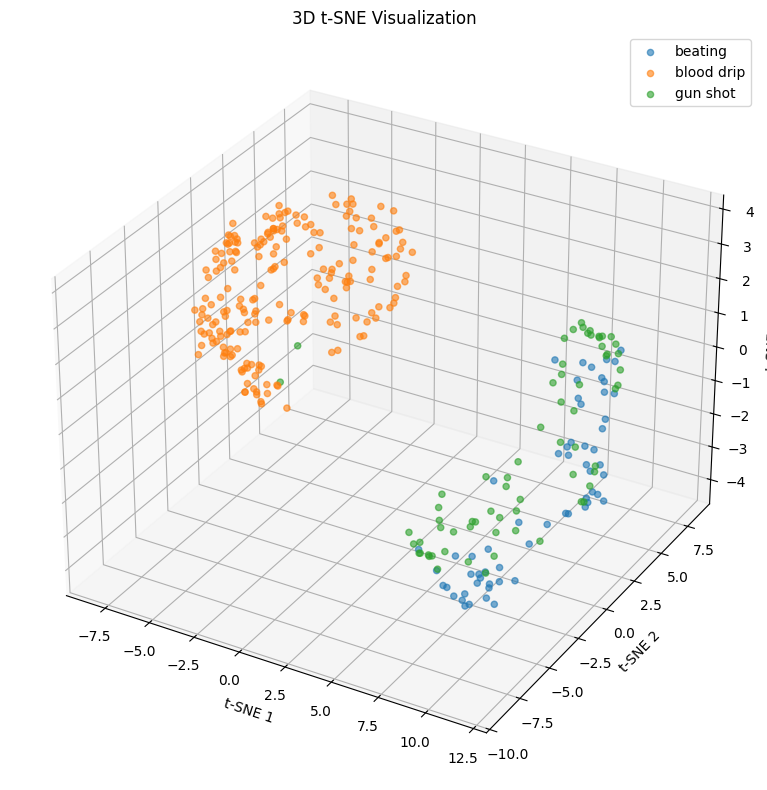

In [66]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2], label=label, s=20, alpha=0.6)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('3D t-SNE Visualization')
ax.legend()

plt.tight_layout()
plt.show()